In [2]:
import os
import warnings
warnings.simplefilter("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from argparse import ArgumentParser

In [3]:
def process(df, colunms, window_size, step_size):
    df_windows = pd.DataFrame(columns=colunms)
    df_group = df.groupby(["activity_type", "subject_id"])
    for recording_id, recording in df_group:
        all_windows = [window for window in recording.rolling(window=window_size, min_periods=window_size) if len(window) == window_size]
        overlapping_windows = all_windows[::step_size]
        overlapping_windows = pd.concat(overlapping_windows).reset_index(drop=True)
        df_windows = pd.concat([df_windows, overlapping_windows])

    df_windows = df_windows.reset_index(drop = True)
    for i in range(1, int(len(df_windows) / 50) + 1):
        df_windows.loc[(i - 1) * 50 : i * 50, 'window_id'] = int(i)
    return df_windows

def data_preprocess(test_data_path, window_size, step_size, class_labels):
    df = pd.read_csv(test_data_path)
    respeck_columns = ["accel_x", "accel_y", "accel_z", "gyro_x", "gyro_y", "gyro_z"]
    df_windows = process(df, respeck_columns, window_size, step_size)
    df_windows['window_id'] = df_windows['window_id'].astype('int32')
    columns_of_interest = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

    X_test = []
    y_test = []
    for window_id, group in df_windows.groupby('window_id'):
        shape = group[columns_of_interest].values.shape
        X_test.append(group[columns_of_interest].values)
        y_test.append(class_labels[group["activity_type"].values[0]])
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test)
    y_test = np.repeat(y_test.reshape(y_test.shape[0], 1), X_test.shape[1], axis=1)
    return X_test, y_test

def model_inference(model_path, X_test):
    interpreter = tf.lite.Interpreter(model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    y_pred_tflite = []
    for X_test_tensor in X_test:
        input_data = tf.cast(X_test_tensor, tf.float32)
        input_data = np.expand_dims(input_data, axis=0)
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        y_pred_tflite.append(output_data)
    y_pred_tflite = np.concatenate(y_pred_tflite, axis=0)
    y_pred_tflite = y_pred_tflite.reshape(-1, y_pred_tflite.shape[-1])
    y_pred_tflite = np.argmax(y_pred_tflite, axis=1)
    return y_pred_tflite

def print_classification_report(y_test, y_pred_tflite):
    print(
        classification_report(
            class_labels[y_test],
            class_labels[y_pred_tflite],
            labels=class_labels,
            digits=3,
        )
    )
def print_metric_per_class(y_test, y_pred_tflite):
    accuracy = {}
    precision = {}
    recall = {}
    f1 = {}
    y_test_ss = np.concatenate(
        (y_test[y_test_label[9]], y_test[y_test_label[12]], y_test[y_test_label[10]], y_test[y_test_label[11]]))
    y_pred_tflite_ss = np.concatenate((y_pred_tflite[y_pred_label[9]], y_pred_tflite[y_test_label[12]],
                                       y_pred_tflite[y_pred_label[10]], y_pred_tflite[y_test_label[11]]))
    accuracy['Sitting/Standing'] = accuracy_score(y_test_ss, y_pred_tflite_ss)
    precision['Sitting/Standing'] = precision_score(y_test_ss, y_pred_tflite_ss, average='weighted')
    recall['Sitting/Standing'] = recall_score(y_test_ss, y_pred_tflite_ss, average='weighted', zero_division=0)
    f1['Sitting/Standing'] = f1_score(y_test_ss, y_pred_tflite_ss, average='weighted')
    print(
        f"Sitting/Standing ………………. Accuracy: {accuracy['Sitting/Standing']:>.3f}, Precision: {precision['Sitting/Standing']:>.3f}, Recall: {recall['Sitting/Standing']:>.3f}, F-score: {f1['Sitting/Standing']:>.3f}")

    for i, label in enumerate(class_labels):
        if label == 'Sitting' or label == 'Standing':
            continue
        accuracy[label] = accuracy_score(y_test[y_test_label[i]], y_pred_tflite[y_pred_label[i]])
        precision[label] = precision_score(y_test[y_test_label[i]], y_pred_tflite[y_pred_label[i]], average='weighted')
        recall[label] = recall_score(y_test[y_test_label[i]], y_pred_tflite[y_pred_label[i]], average='weighted',
                                     zero_division=0)
        f1[label] = f1_score(y_test[y_test_label[i]], y_pred_tflite[y_pred_label[i]], average='weighted')
        print(f"{label} ………………. Accuracy: {accuracy[label]:>.3f}, Precision: {precision[label]:>.3f}, Recall: {recall[label]:>.3f}, F-score: {f1[label]:>.3f}")

def save_confusion_matrix_plot(y_test, y_pred_tflite):
    try:
        fig, ax = plt.subplots(figsize=(14, 14))
        cm = confusion_matrix(
            class_labels[y_test],
            class_labels[y_pred_tflite],
            labels=class_labels,
            normalize='true'
        )
        sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
        ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.3f')
        ax.set_yticklabels(class_labels, rotation=0)
        ax.set_xticklabels(class_labels, rotation=60)
        ax.set_ylabel('True labels', fontsize=21)
        ax.set_xlabel('Predicted labels', fontsize=21)
        ax.collections[0].colorbar.set_label('Accuracy', fontsize=21)
        fig.savefig('./confusion_matrix_model.png')
        print("Successfully save the confusion matrix plot.")
    except:
        print("Exception: Unable to save the confusion matrix plot.")

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Model metrics report:
------------------------------------------------------------------------------------------------------------------------
                         precision    recall  f1-score   support

        Climbing stairs      0.985     0.987     0.986      1118
      Descending stairs      0.979     0.993     0.986      1149
              Desk work      0.980     0.980     0.980      1347
        Lying down left      0.953     0.975     0.964      1350
     Lying down on back      0.992     0.961     0.976      1356
  Lying down on stomach      0.975     0.979     0.977      1357
       Lying down right      0.959     0.954     0.957      1349
               Movement      0.978     0.987     0.982      1350
                Running      1.000     0.999     1.000      1318
                Sitting      0.986     0.984     0.985      1339
  Sitting bent backward      0.941     0.959     0.950      1340
   Sitting bent forward      0.978     0.972     0.975      1341
           

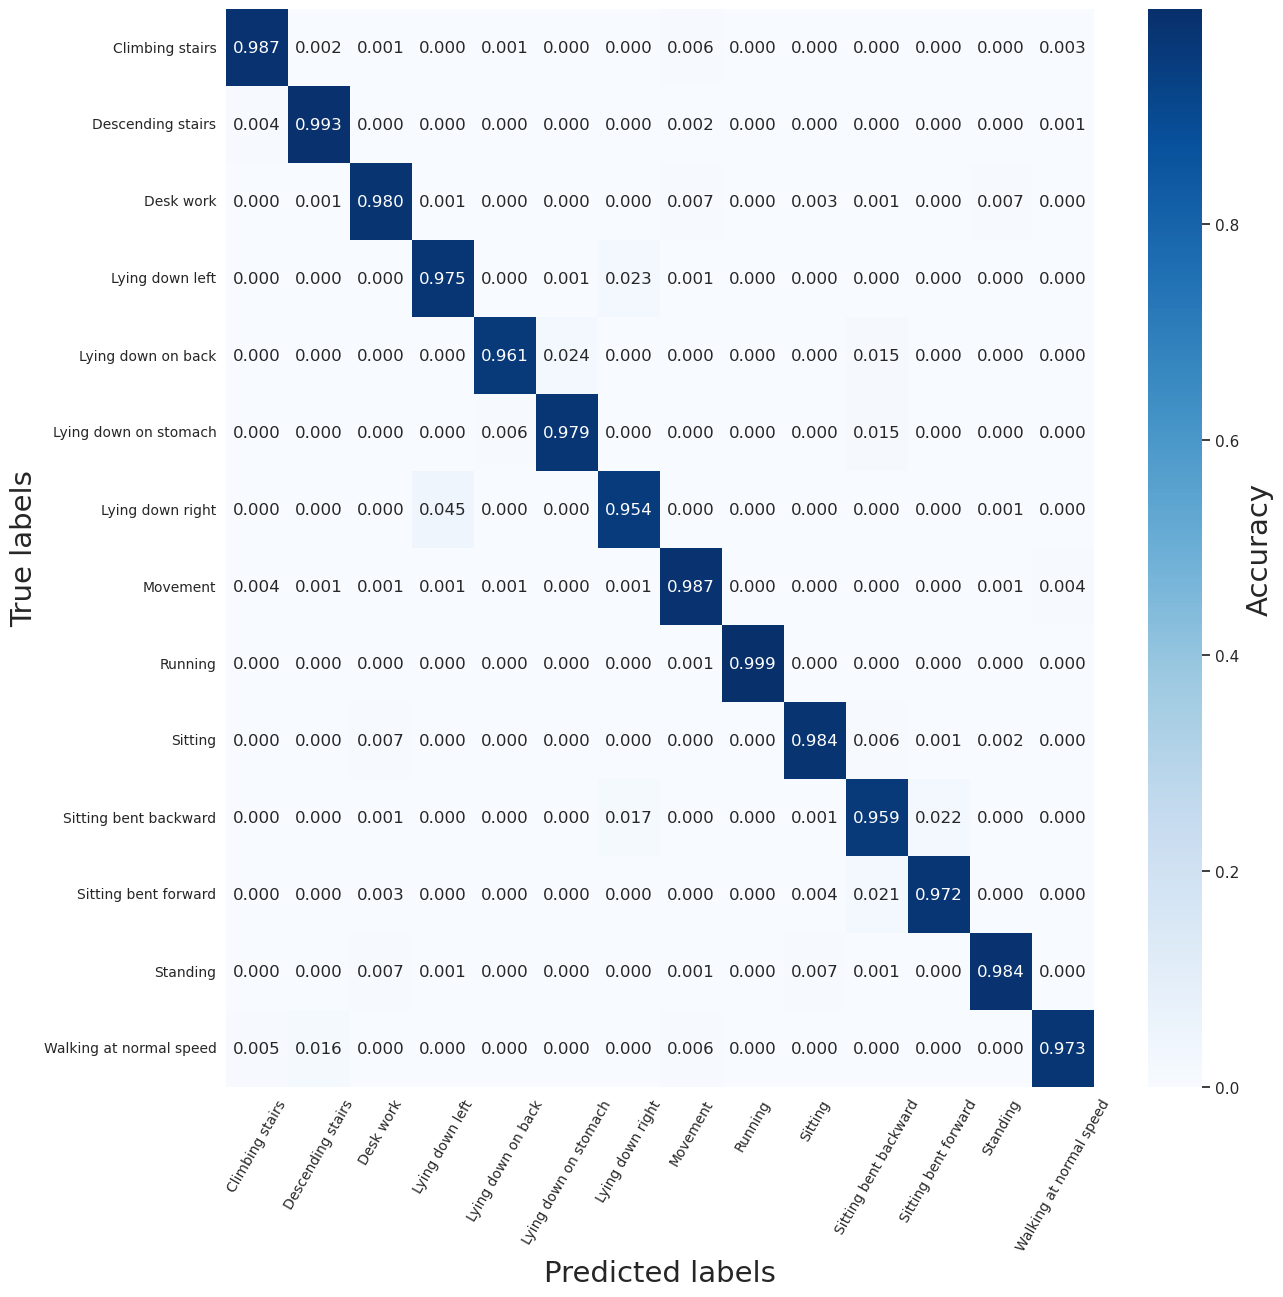

In [4]:
# parser = ArgumentParser(description='Group D - Human Activity Recognition Model')
# parser.add_argument('--model_path', '-mp', default='./Model/HAR_Transformer.tflite', type=str, help='model file path')
# parser.add_argument('--test_data_path', '-dp', default='./Data/dataset.csv', type=str, help='The default path is the training data. If you want to test the performance on other test set, please input the path of the .csv file.')
# args = parser.parse_args()

# Data Preprocess
window_size = 50  # 50 datapoints for the window size, which, at 25Hz, means 2 seconds
step_size = 25  # this is 50% overlap
class_labels = {
    'Climbing stairs': 0,
    'Descending stairs': 1,
    'Desk work': 2,
    'Lying down left': 3,
    'Lying down on back': 4,
    'Lying down on stomach': 5,
    'Lying down right': 6,
    'Movement': 7,
    'Running': 8,
    'Sitting': 9,
    'Sitting bent backward': 10,
    'Sitting bent forward': 11,
    'Standing': 12,
    'Walking at normal speed': 13
}
test_data_path = './pdiot-data/Respeck_recordings_clean.csv'
model_path = 'models/Final/HAR_transformer.tflite'
X_test, y_test = data_preprocess(test_data_path, window_size, step_size, class_labels)

# TFlite Model Inference
y_pred_tflite = model_inference(model_path, X_test)

# Produce Metrics Report
class_labels = np.asarray(list(class_labels.keys()))
y_test = y_test[:, 0]
idxs = []
for i in range(0, 14):
    idx = np.argwhere(y_test == i).reshape(-1)
    idxs.append(idx)
y_test_label = []
y_pred_label = []
for i, label_idx in enumerate(idxs):
    y_test_label.append(label_idx)
    y_pred_label.append(label_idx)

print("Model metrics report:")
## Classification report
print('-' * 120)
print_classification_report(y_test, y_pred_tflite)

## Performance of each class
print('-' * 120)
print_metric_per_class(y_test, y_pred_tflite)

## Confusion matrix
print('-' * 120)
save_confusion_matrix_plot(y_test, y_pred_tflite)